In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gym
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torch_deep_q_model import DeepQNetwork, Agent
#from utils import plotLearning
import numpy as np
import random
from gym import wrappers
import math
print(T.cuda.is_available())

True


In [2]:
class DeepQNetwork(nn.Module):
    def __init__(self, ALPHA):
        super(DeepQNetwork, self).__init__()
        #self.conv1 = nn.Conv2d(3, 32, 8, stride=4, padding=1)
        self.conv1 = nn.Conv2d(1, 32, 8, stride=4, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 3)
        #self.fc1 = nn.Linear(128*23*16, 512)
        self.fc1 = nn.Linear(128*19*8, 512)
        self.fc2 = nn.Linear(512, 6)
        #self.optimizer = optim.SGD(self.parameters(), lr=self.ALPHA, momentum=0.9)
        self.optimizer = optim.RMSprop(self.parameters(), lr=ALPHA)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, observation):
        observation = T.Tensor(observation).to(self.device)
        #observation = observation.view(-1, 3, 210, 160).to(self.device)
        observation = observation.view(-1, 1, 185, 95)
        observation = F.relu(self.conv1(observation))
        observation = F.relu(self.conv2(observation))
        observation = F.relu(self.conv3(observation))
        #observation = observation.view(-1, 128*23*16).to(self.device)
        observation = observation.view(-1, 128*19*8)
        observation = F.relu(self.fc1(observation))
        actions = self.fc2(observation)
        return actions

class Agent(object):
    def __init__(self, gamma, epsilon, alpha,
                 maxMemorySize, epsEnd=0.05,
                 replace=10000, actionSpace=[0,1,2,3,4,5]):
        self.GAMMA = gamma
        self.EPSILON = epsilon
        self.EPS_END = epsEnd
        self.ALPHA = alpha
        self.actionSpace = actionSpace
        self.memSize = maxMemorySize
        self.steps = 0
        self.learn_step_counter = 0
        self.memory = []
        self.memCntr = 0
        self.replace_target_cnt = replace
        self.Q_eval = DeepQNetwork(alpha)
        self.Q_next = DeepQNetwork(alpha)
        self.score = 0

    def storeTransition(self, state, action, reward, state_):
        if self.memCntr < self.memSize:
            self.memory.append([state, action, reward, state_])
        else:
            self.memory[self.memCntr%self.memSize] = [state, action, reward, state_]
        self.memCntr += 1

    def chooseAction(self, observation):
        rand = np.random.random()
        actions = self.Q_eval.forward(observation)
        if rand < 1 - self.EPSILON:
            action = T.argmax(actions[1]).item()
        else:
            action = np.random.choice(self.actionSpace)
        self.steps += 1
        return action

    def chooseActionPBT(self, observation, policy_net_parent=None):
        rand = np.random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * self.steps / EPS_DECAY)
        self.steps += 1
        if rand > eps_threshold:
            return T.argmax(self.Q_eval.forward(observation)[1]).item() #self.Q_eval.forward(observation).max(1)[1].view(1, 1)
        else:
            if policy_net_parent and random.random() < 0.5:
                return T.argmax(policy_net_parent(observation)[1]).item() #policy_net_parent(observation).max(1)[1].view(1, 1)
            else:
                return np.random.choice(self.actionSpace) #T.tensor([[random.randrange(self.actionSpace)]], device=device, dtype=T.long)

    def learn(self, batch_size):
        self.Q_eval.optimizer.zero_grad()
        if self.replace_target_cnt is not None and \
           self.learn_step_counter % self.replace_target_cnt == 0:
            self.Q_next.load_state_dict(self.Q_eval.state_dict())

        if self.memCntr+batch_size < self.memSize:
            memStart = int(np.random.choice(range(self.memCntr)))
        else:
            memStart = int(np.random.choice(range(self.memSize-batch_size-1)))
        miniBatch=self.memory[memStart:memStart+batch_size]
        memory = np.array(miniBatch)

        # convert to list because memory is an array of numpy objects
        Qpred = self.Q_eval.forward(list(memory[:,0][:])).to(self.Q_eval.device)
        Qnext = self.Q_next.forward(list(memory[:,3][:])).to(self.Q_eval.device)

        maxA = T.argmax(Qnext, dim=1).to(self.Q_eval.device)
        rewards = T.Tensor(list(memory[:,2])).to(self.Q_eval.device)
        Qtarget = Qpred.clone()
        indices = np.arange(batch_size)
        Qtarget[indices,maxA] = rewards + self.GAMMA*T.max(Qnext[1])

        if self.steps > 500:
            if self.EPSILON - 1e-4 > self.EPS_END:
                self.EPSILON -= 1e-4
            else:
                self.EPSILON = self.EPS_END

        #Qpred.requires_grad_()
        loss = self.Q_eval.loss(Qtarget, Qpred).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()
        self.learn_step_counter += 1


In [3]:
def plotLearning(x, scores, epsilons, filename, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    #ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Score', color="C1")
    #ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)

Training a single agent:

done initializing memory
starting game  1 epsilon: 1.0000
score: 75.0
starting game  2 epsilon: 1.0000
score: 140.0
starting game  3 epsilon: 1.0000
score: 105.0
starting game  4 epsilon: 0.9756
score: 130.0
starting game  5 epsilon: 0.9100
score: 65.0
starting game  6 epsilon: 0.8411
score: 80.0
starting game  7 epsilon: 0.7725
score: 160.0
starting game  8 epsilon: 0.6930
score: 45.0
starting game  9 epsilon: 0.6411
score: 45.0
starting game  10 epsilon: 0.6015
score: 20.0
starting game  11 epsilon: 0.5624
score: 335.0
starting game  12 epsilon: 0.4485
score: 10.0
starting game  13 epsilon: 0.4136
score: 255.0
starting game  14 epsilon: 0.3152
score: 25.0
starting game  15 epsilon: 0.2751
score: 235.0
starting game  16 epsilon: 0.2052
score: 225.0
starting game  17 epsilon: 0.0909
score: 275.0
starting game  18 epsilon: 0.0500
score: 590.0
starting game  19 epsilon: 0.0500
score: 395.0
starting game  20 epsilon: 0.0500
score: 220.0
starting game  21 epsilon: 0.0500
score: 90.0
starti

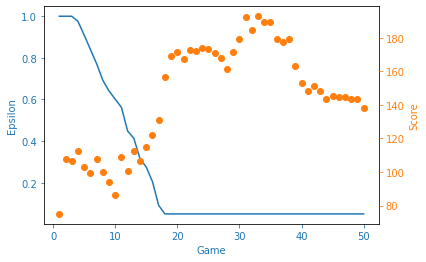

In [ ]:
    env = gym.make('SpaceInvaders-v0')
    brain = Agent(gamma=0.95, epsilon=1.0,
                  alpha=0.003, maxMemorySize=5000,
                  replace=None)
    while brain.memCntr < brain.memSize:
        observation = env.reset()
        done = False
        while not done:
            # 0 no action, 1 fire, 2 move right, 3 move left, 4 move right fire, 5 move left fire
            action = env.action_space.sample()
            observation_, reward, done, info = env.step(action)
            if done and info['ale.lives'] == 0:
                reward = -100
            brain.storeTransition(np.mean(observation[15:200,30:125], axis=2), action, reward,
                                np.mean(observation_[15:200,30:125], axis=2))
            observation = observation_
    print('done initializing memory')

    scores = []
    epsHistory = []
    numGames = 50
    batch_size=32
    # uncomment the line below to record every episode.
    env = wrappers.Monitor(env, "tmp/space-invaders-1", video_callable=lambda episode_id: True, force=True)
    for i in range(numGames):
        print('starting game ', i+1, 'epsilon: %.4f' % brain.EPSILON)
        epsHistory.append(brain.EPSILON)
        done = False
        observation = env.reset()
        frames = [np.sum(observation[15:200,30:125], axis=2)]
        score = 0
        lastAction = 0
        while not done:
            if len(frames) == 3:
                action = brain.chooseAction(frames)
                frames = []
            else:
                action = lastAction
            observation_, reward, done, info = env.step(action)
            score += reward
            frames.append(np.sum(observation_[15:200,30:125], axis=2))
            if done and info['ale.lives'] == 0:
                reward = -100
            brain.storeTransition(np.mean(observation[15:200,30:125], axis=2), action, reward,
                                  np.mean(observation_[15:200,30:125], axis=2))
            observation = observation_
            brain.learn(batch_size)
            lastAction = action
            #env.render(
        scores.append(score)
        print('score:',score)
    x = [i+1 for i in range(numGames)]
    fileName = str(numGames) + 'Games' + 'Gamma' + str(brain.GAMMA) + \
               'Alpha' + str(brain.ALPHA) + 'Memory' + str(brain.memSize)+ '.png'
    plotLearning(x, scores, epsHistory, fileName)

Population Based Training


In [4]:
TARGET_UPDATE = 10
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

In [7]:
    env = gym.make('SpaceInvaders-v0')


    scores = []
    #epsHistory = []
    numGames = 4
    batch_size= 32
    # uncomment the line below to record every episode.
    env = wrappers.Monitor(env, "tmp/space-invaders-1", video_callable=lambda episode_id: True, force=True)
    no_agents = 15
    generations = 3
    best_parent = None
    best_score = 0

    for g in range(generations):
        print('Training for generation:', g)
        for a in range(no_agents):
            total_score = 0
            agent_score = []
            epsHistory = []

            brain = Agent(gamma=0.95, epsilon=1.0,
                  alpha=0.003, maxMemorySize=5000,
                  replace=None)
            while brain.memCntr < brain.memSize:
                observation = env.reset()
                done = False
                while not done:
            # 0 no action, 1 fire, 2 move right, 3 move left, 4 move right fire, 5 move left fire
                    action = env.action_space.sample()
                    observation_, reward, done, info = env.step(action)
                    if done and info['ale.lives'] == 0:
                        reward = -100
                    brain.storeTransition(np.mean(observation[15:200,30:125], axis=2), action, reward,
                                np.mean(observation_[15:200,30:125], axis=2))
                    observation = observation_
            print('done initializing memory for agent ', a)
            #print('best parent', best_parent)

            for i in range(numGames):
                print('starting game ', i+1, 'epsilon: %.4f' % brain.EPSILON)
                epsHistory.append(brain.EPSILON)
                done = False
                observation = env.reset()
                frames = [np.sum(observation[15:200,30:125], axis=2)]
                score = 0
                lastAction = 0
                while not done:
                    print("len",len(frames))
                    if len(frames) == 3:
                        action = brain.chooseActionPBT(frames, best_parent)
                        frames = []
                    else:
                        action = lastAction
                    observation_, reward, done, info = env.step(action)
                    score += reward
                    frames.append(np.sum(observation_[15:200,30:125], axis=2))
                    if done and info['ale.lives'] == 0:
                        reward = -100
                    brain.storeTransition(np.mean(observation[15:200,30:125], axis=2), action, reward,
                                  np.mean(observation_[15:200,30:125], axis=2))
                    observation = observation_
                    brain.learn(batch_size)
                    lastAction = action
                total_score += score

                if i % TARGET_UPDATE == 0:
                    brain.Q_next.load_state_dict(brain.Q_eval.state_dict())
                  
                #env.render()
                scores.append(score)
                agent_score.append(score)
                print('score:',score)
            #x = [i+1 for i in range(numGames)]
            #fileName = str(numGames) + 'Games' + 'Gamma' + str(brain.GAMMA) + \
             #      'Alpha' + str(brain.ALPHA) + 'Memory' + str(brain.memSize)+ '.png'
            #plotLearning(x, agent_score, epsHistory, fileName)
            if total_score/(numGames) > best_score: #average score
                print("Found best in current generation", total_score/numGames)
                best_score = total_score/numGames
                best_curr = brain.Q_eval
        best_parent = best_curr
    print('Best Average Score:', best_score)

Training for generation: 0
done initializing memory for agent  0
starting game  1 epsilon: 1.0000
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2
len 3
len 1
len 2


KeyboardInterrupt: ignored

Baseline Approach: Shared Buffer

In [4]:
TARGET_UPDATE = 10
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

In [5]:
class Agent_Baseline(object):
    def __init__(self, gamma, epsilon, alpha,
                 maxMemorySize, epsEnd=0.05,
                 replace=10000, actionSpace=[0,1,2,3,4,5]):
        self.GAMMA = gamma
        self.EPSILON = epsilon
        self.EPS_END = epsEnd
        self.ALPHA = alpha
        self.actionSpace = actionSpace
        self.memSize = maxMemorySize
        self.steps = 0
        self.learn_step_counter = 0
        self.memory = []
        self.memCntr = 0
        self.replace_target_cnt = replace
        self.Q_eval = DeepQNetwork(alpha)
        self.Q_next = DeepQNetwork(alpha)
        self.score = 0
        self.env = gym.make('SpaceInvaders-v0').unwrapped
        self.lastAction = 0
        self.observation = None
        self.done = False
        self.frames = []


    def storeTransition(self, state, action, reward, state_):
        if self.memCntr < self.memSize:
            self.memory.append([state, action, reward, state_])
        else:
            self.memory[self.memCntr%self.memSize] = [state, action, reward, state_]
        self.memCntr += 1

    def chooseAction(self, observation):
        rand = np.random.random()
        actions = self.Q_eval.forward(observation)
        if rand < 1 - self.EPSILON:
            action = T.argmax(actions[1]).item()
        else:
            action = np.random.choice(self.actionSpace)
        self.steps += 1
        return action

    def chooseActionPBT(self, observation, policy_net_parent=None):
        rand = np.random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * self.steps / EPS_DECAY)
        self.steps += 1
        if rand > eps_threshold:
            return T.argmax(self.Q_eval.forward(observation)[1]).item() #self.Q_eval.forward(observation).max(1)[1].view(1, 1)
        else:
            if policy_net_parent and random.random() < 0.5:
                return T.argmax(policy_net_parent(observation)[1]).item() #policy_net_parent(observation).max(1)[1].view(1, 1)
            else:
                return np.random.choice(self.actionSpace) #T.tensor([[random.randrange(self.actionSpace)]], device=device, dtype=T.long)

    def learn(self, batch_size):
        self.Q_eval.optimizer.zero_grad()
        if self.replace_target_cnt is not None and \
           self.learn_step_counter % self.replace_target_cnt == 0:
            self.Q_next.load_state_dict(self.Q_eval.state_dict())

        #print(self.memCntr, batch_size, self.memSize)
        if self.memCntr+batch_size < self.memSize:
            memStart = int(np.random.choice(range(self.memCntr)))
        else:
            memStart = int(np.random.choice(range(self.memSize-batch_size-1)))
        miniBatch=self.memory[memStart:memStart+batch_size]
        memory = np.array(miniBatch)

        # convert to list because memory is an array of numpy objects
        Qpred = self.Q_eval.forward(list(memory[:,0][:])).to(self.Q_eval.device)
        Qnext = self.Q_next.forward(list(memory[:,3][:])).to(self.Q_eval.device)

        maxA = T.argmax(Qnext, dim=1).to(self.Q_eval.device)
        rewards = T.Tensor(list(memory[:,2])).to(self.Q_eval.device)
        Qtarget = Qpred.clone()
        indices = np.arange(batch_size)
        Qtarget[indices,maxA] = rewards + self.GAMMA*T.max(Qnext[1])

        if self.steps > 500:
            if self.EPSILON - 1e-4 > self.EPS_END:
                self.EPSILON -= 1e-4
            else:
                self.EPSILON = self.EPS_END

        #Qpred.requires_grad_()
        loss = self.Q_eval.loss(Qtarget, Qpred).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()
        self.learn_step_counter += 1


In [6]:
    env = gym.make('SpaceInvaders-v0')


    scores = []
    #epsHistory = []
    numGames = 2
    batch_size= 32
    # uncomment the line below to record every episode.
    env = wrappers.Monitor(env, "tmp/space-invaders-1", video_callable=lambda episode_id: True, force=True)
    no_agents = 2
    generations = 2
    best_parent = None
    best_score = 0

    for g in range(generations):
        print('Training for generation:', g)
        total_score = 0
        agent_score = []
        epsHistory = []

        agents = [Agent_Baseline(gamma=0.95, epsilon=1.0,
              alpha=0.003, maxMemorySize=5000,
              replace=None) for _ in range(no_agents)]

        brain = agents[0] #shared memory
        while brain.memCntr < brain.memSize:
            observation = brain.env.reset()
            done = False
            while not done:
            # 0 no action, 1 fire, 2 move right, 3 move left, 4 move right fire, 5 move left fire
                action = env.action_space.sample()
                observation_, reward, done, info = brain.env.step(action)
                if done and info['ale.lives'] == 0:
                    reward = -100
                brain.storeTransition(np.mean(observation[15:200,30:125], axis=2), action, reward,
                            np.mean(observation_[15:200,30:125], axis=2))
                observation = observation_
        print('done initializing shared memory for agents ')
        #print('best parent', best_parent)
  
        for i in range(numGames):
            print('starting game ', i+1)
            for a in agents:
              a.observation = a.env.reset()
              a.frames = [np.sum(a.observation[15:200,30:125], axis=2)]

            running = [1]*no_agents

            while sum(running) > 1:
                for j, a in enumerate(agents):
                  if running[j]:
                    epsHistory.append(a.EPSILON)
                    if len(a.frames) == 3:
                        action = a.chooseActionPBT(a.frames, best_parent)
                        a.frames = []
                    else:
                        action = a.lastAction
                    observation_, reward, a.done, info = a.env.step(action)
                    #print(action, a.observation, reward, a.done, info)
                    a.score += reward

                    a.frames.append(np.sum(observation_[15:200,30:125], axis=2))
                    if a.done and info['ale.lives'] == 0:
                      reward = -100
                    if a.done:
                      running[j] = 0
                      break
                    brain.storeTransition(np.mean(a.observation[15:200,30:125], axis=2), action, reward,
                              np.mean(observation_[15:200,30:125], axis=2))
                    a.memory = brain.memory
                    a.observation = observation_
                    brain.learn(batch_size)
                    a.lastAction = action

            if i % TARGET_UPDATE == 0:
              for a in agents:
                a.Q_next.load_state_dict(a.Q_eval.state_dict())
          
        max_score = -1
        best_a = None
        for a in agents:
          if a.score > max_score:
            max_score = a.score
            best_a = a

        #print(max_score, numGames, best_score)
        if max_score/numGames > best_score: #average score
            print("Found best in current generation", max_score/numGames)
            best_score = max_score/numGames
            best_curr = best_a.Q_eval
        best_parent = best_curr
    print('Best Average Score:', best_score)

Training for generation: 0
done initializing shared memory for agents 
starting game  1
starting game  2
530.0 2 0
Found best in current generation 265.0
Training for generation: 1
done initializing shared memory for agents 
starting game  1
starting game  2
400.0 2 265.0
Best Average Score: 265.0
